# Causal Analysis of Educational Factors on Student Performance

## Abstract

What truly drives student success? In this notebook, we dive into the world of causal inference to uncover how educational factors—like parental education, economic status, and test preparation—actually impact student performance. Using a rich student dataset, we walk through the full pipeline: from data exploration and feature engineering to identifying confounders and estimating causal effects. Along the way, we apply powerful tools such as regression modeling, matching techniques, and propensity score analysis to reveal insights that go beyond correlation. By the end, you'll gain a clear understanding of how thoughtful data preparation and causal reasoning can lead to more informed, impactful educational decisions—shifting the focus from what is related to what truly causes change. Whether you're a data scientist, educator, or policy-maker, this notebook equips you with a practical framework for building evidence-based interventions that make a difference.

<img src="https://theaseanmagazine.asean.org/files/media/2024/07/issue38-06-1.jpg" width="1200"/>

## 1. Introduction to Causality

### 1.1 The Importance of Causality in Educational Research

In educational research and policy, we often want to understand not just correlations but causal relationships: "Does test preparation *cause* higher test scores?" This distinction is crucial for effective interventions. For example, educators might want to know whether completing a test preparation course *causes* an increase in math scores, not just whether they are correlated.

### 1.2 Key Concepts in Causal Inference

#### Correlation vs. Causation

Correlation measures the statistical association between variables, while causation implies that changes in one variable directly influence another. The classic example "correlation does not imply causation" reminds us that observed associations may be due to:
- Reverse causality
- Common causes (confounding)
- Coincidence
- Selection bias

#### Causal Graphs (DAGs)

Directed Acyclic Graphs (DAGs) are powerful tools for representing causal relationships. In a DAG:
- Nodes represent variables
- Directed edges represent causal relationships
- The graph contains no cycles

#### Potential Outcomes Framework

The potential outcomes framework, developed by Rubin and others, formalizes causal inference:
- For each student i, we define potential outcomes Y_i(0) and Y_i(1) under control and treatment
- The causal effect is the difference: Y_i(1) - Y_i(0)
- The fundamental problem of causal inference: we only observe one potential outcome for each student

## 2. Data Preparation for Causal Analysis

Let's begin by loading and exploring the student performance dataset.



In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import networkx as nx
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors
import warnings

warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")


# Local file path if you already uploaded it to your environment
file_path = "StudentsPerformance.csv"
# Load it using pandas
students_df = pd.read_csv(file_path)


# Display the first few rows
print("Dataset Overview:")
students_df.head()

Dataset Overview:


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


### 🔍 Dataset Snapshot: First Glimpse into Student Performance

Let’s take a quick look at the first five entries in our dataset. Here’s what we see:

| Gender | Race/Ethnicity | Parental Education | Lunch         | Test Prep     | Math | Reading | Writing |
|--------|----------------|--------------------|---------------|---------------|------|---------|---------|
| Female | Group B        | Bachelor's degree  | Standard      | None          | 72   | 72      | 74      |
| Female | Group C        | Some college       | Standard      | Completed     | 69   | 90      | 88      |
| Female | Group B        | Master's degree    | Standard      | None          | 90   | 95      | 93      |
| Male   | Group A        | Associate's degree | Free/Reduced  | None          | 47   | 57      | 44      |
| Male   | Group C        | Some college       | Standard      | None          | 76   | 78      | 75      |

Here are some early insights:

- 📚 **Test Preparation Matters?**  
  Compare Row 1 vs. Row 0 or 4. The student who completed the test prep course scored **very high** in reading and writing—even though their math score was slightly lower. Could this hint at a treatment effect from the prep course?

- 🎓 **Parental Education Level**  
  The student in Row 2, whose parent has a *master’s degree*, scored the highest across all subjects. This supports the hypothesis that higher parental education might positively influence academic performance.

- 🍱 **Lunch as a Proxy for Economic Status**  
  Row 3’s student, receiving *free/reduced lunch*, scored significantly lower across all areas. This could reflect the socioeconomic challenges impacting learning.

- 👧👦 **Gender Distribution**  
  While only a small sample, we notice female students appear slightly more represented and possibly performing better here—something we might explore further in the full dataset.

This snapshot sets the stage for deeper causal exploration. But before drawing any conclusions, we’ll clean, preprocess, and adjust for confounders to rigorously test whether these patterns represent true causal relationships—or just coincidences.


### 2.1 Data Exploration and Preprocessing

Let's examine the dataset structure and prepare it for causal analysis.

In [8]:
# Check dataset information
print("Dataset Shape:", students_df.shape)
print("\nData Types:")
students_df.info()

# Convert score columns from string to numeric
score_cols = ['math score', 'reading score', 'writing score']
for col in score_cols:
    students_df[col] = pd.to_numeric(students_df[col], errors='coerce')

# Check for missing values
print("\nMissing Values:")
print(students_df.isnull().sum())

# Basic statistics
print("\nBasic Statistics:")
students_df.describe()

# Create a total score column
students_df['total score'] = students_df[score_cols].sum(axis=1)
students_df['average score'] = students_df[score_cols].mean(axis=1)

# Check categorical variables
print("\nCategorical Variables:")
for col in students_df.select_dtypes(include=['object']).columns:
    print(f"\n{col}:")
    print(students_df[col].value_counts())

Dataset Shape: (1000, 8)

Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB

Missing Values:
gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score        

### 📊 Dataset Exploration: Who Are Our Students?

Before diving into any causal analysis, it's essential to understand the terrain we're working with—and in this case, that means the students in our dataset.

🔍 **Dataset Overview**
We have data on **1,000 students** with complete entries—no missing values! That’s a great starting point, as it eliminates the need for data imputation or dropping rows.

🧠 **Key Features:**
- **Gender:** Fairly balanced, with 518 females and 482 males.
- **Race/Ethnicity:** Group C dominates (319 students), followed by groups D and B. This tells us we'll need to watch for potential racial/ethnic imbalance when modeling.
- **Parental Level of Education:** Most parents completed *some college* or have an *associate's degree*, with fewer students having parents who reached a *master's degree*.
- **Lunch Program:** 645 students receive *standard lunch*, while 355 receive *free/reduced lunch*, a strong proxy for economic status.
- **Test Preparation Course:** 358 students completed a test prep course, while 642 did not—an ideal setup for treatment vs. control analysis.

📚 **Score Stats:**
- We created a `total score` and `average score` column by combining math, reading, and writing scores. These aggregated measures give us a solid single outcome variable for causal estimation.

✅ **Data Quality:**  
- **No missing values** ✅  
- **Proper data types** (after converting scores to numeric) ✅  
- **Categorical features well-distributed** ✅

This clean and rich dataset gives us the perfect sandbox to study the causal impact of factors like parental education and test preparation on student performance. Let’s now explore these relationships in more detail!


Let's visualize the distribution of scores and key variables.

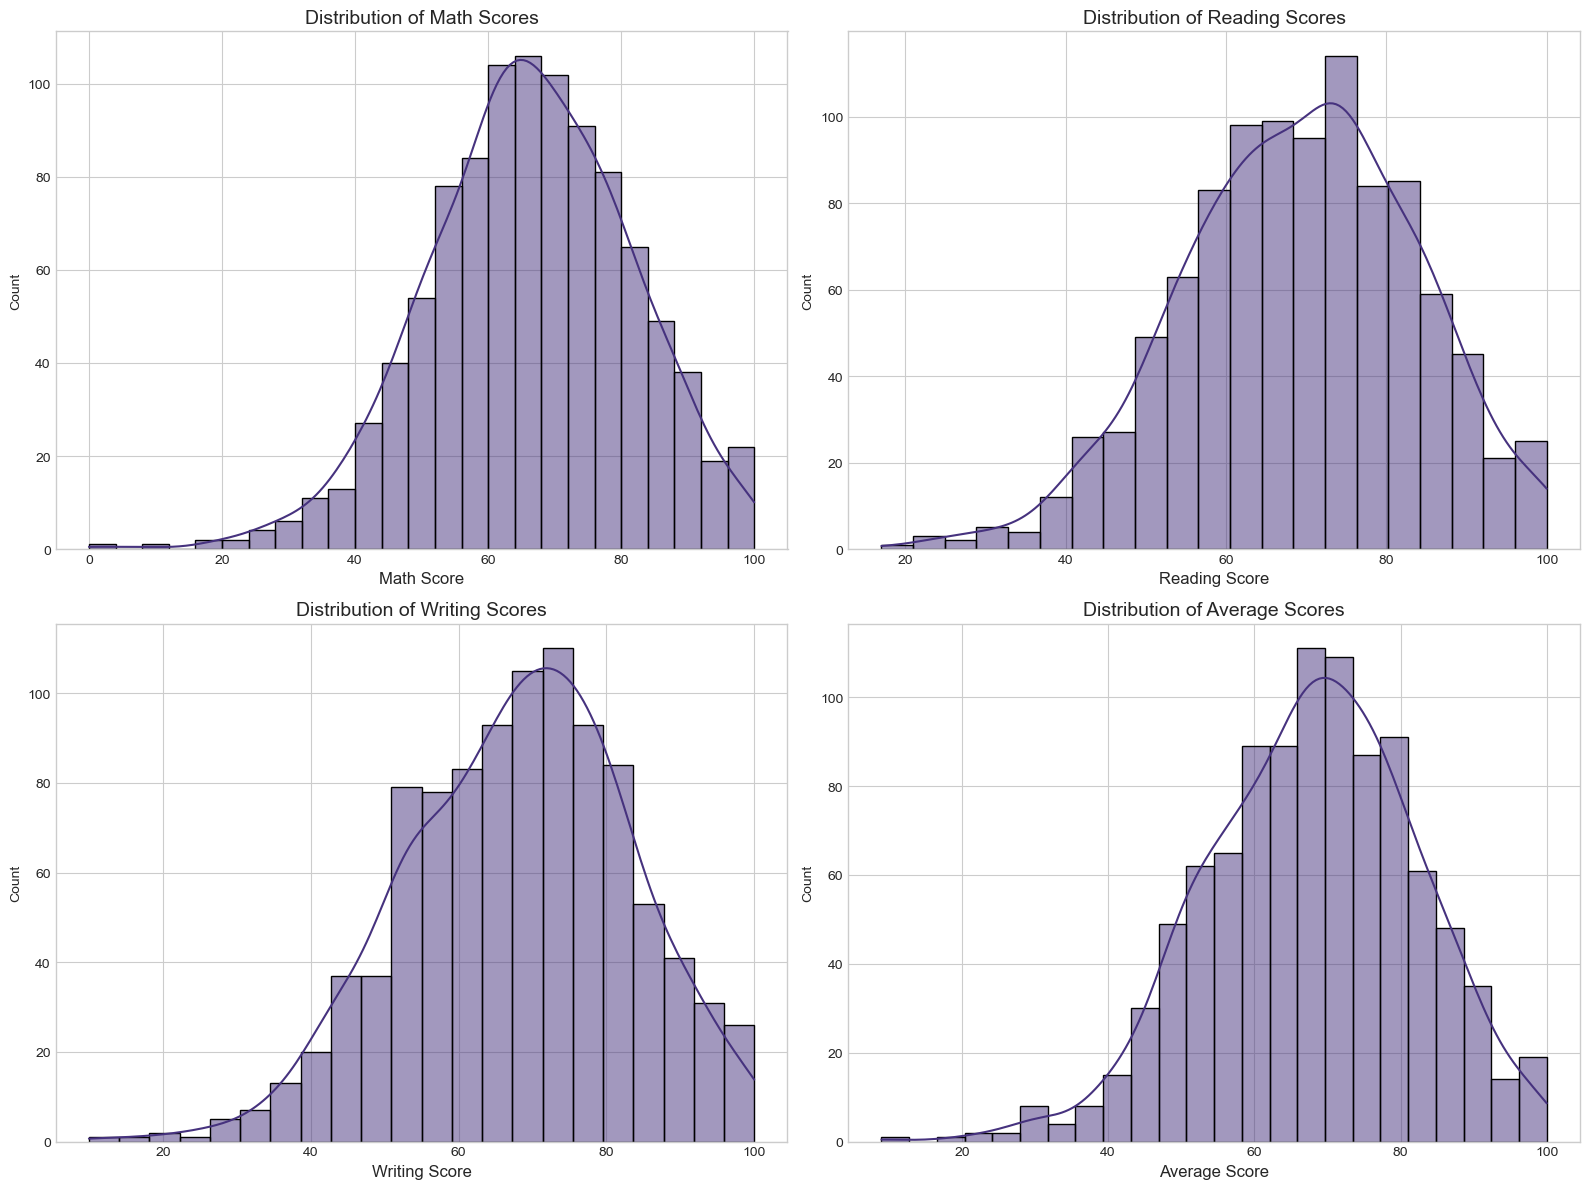

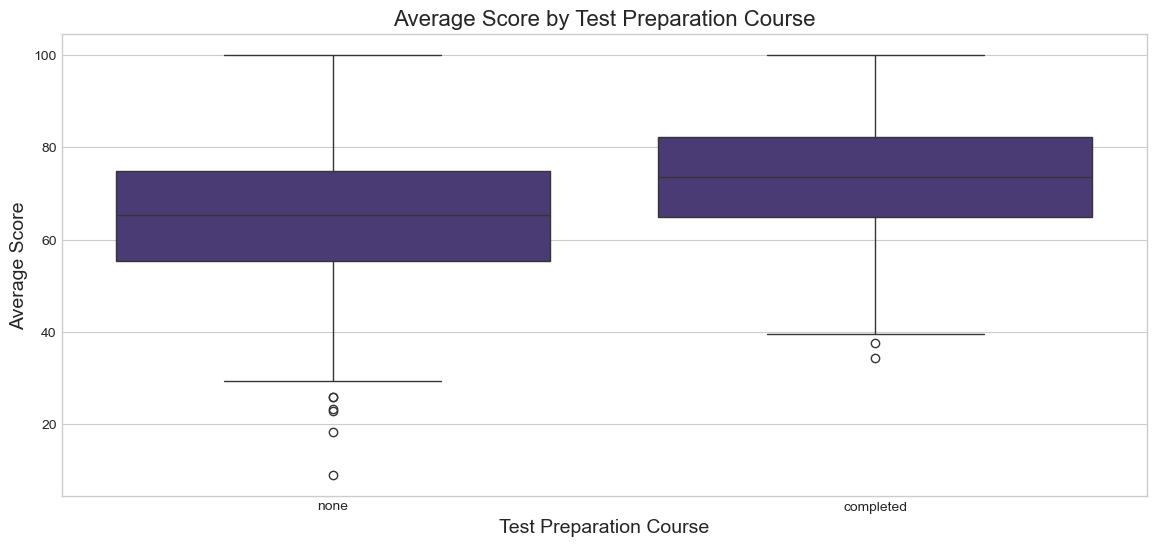

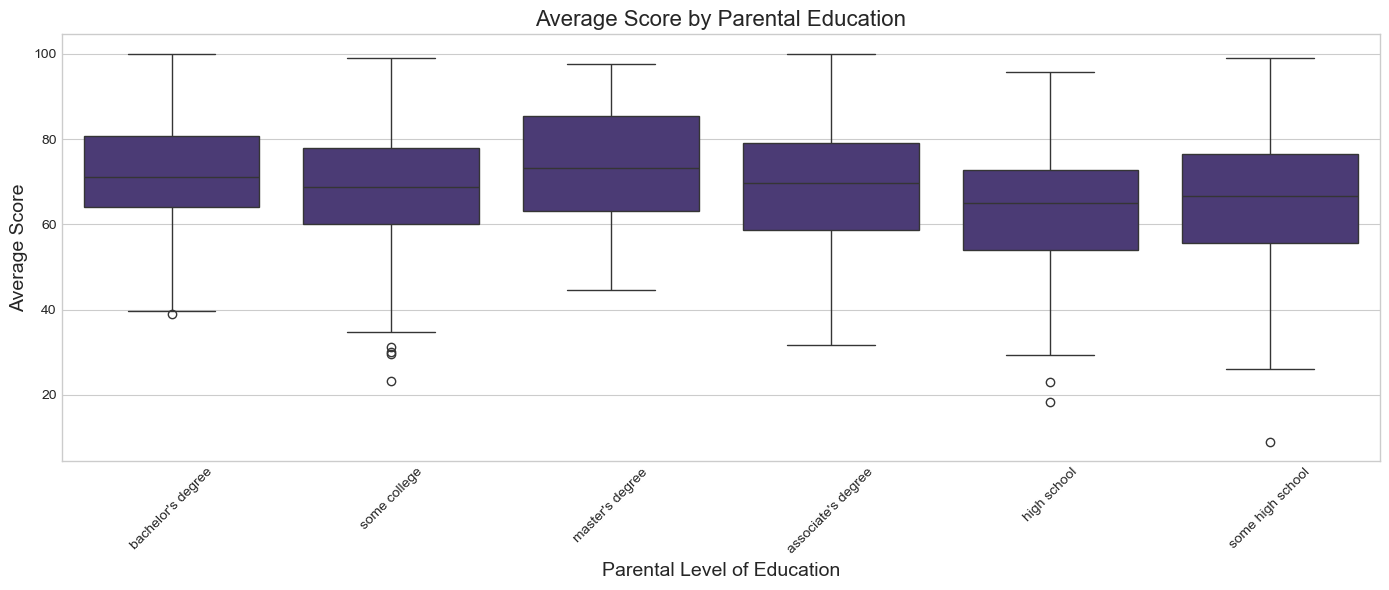

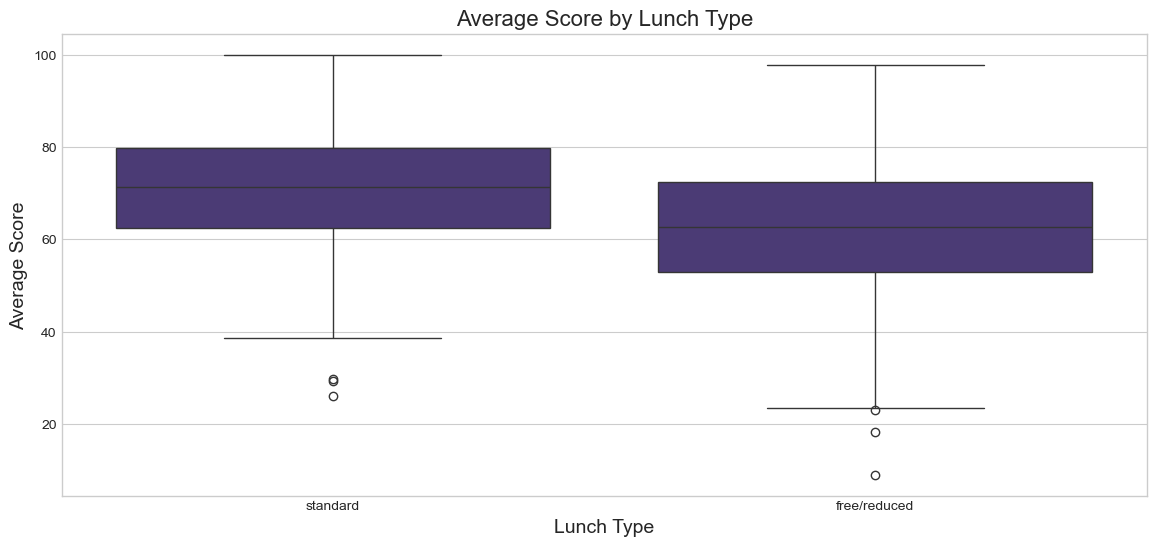

In [39]:
# Set up a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Math Score distribution
sns.histplot(students_df['math score'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Math Scores', fontsize=14)
axes[0, 0].set_xlabel('Math Score', fontsize=12)

# Reading Score distribution
sns.histplot(students_df['reading score'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Reading Scores', fontsize=14)
axes[0, 1].set_xlabel('Reading Score', fontsize=12)

# Writing Score distribution
sns.histplot(students_df['writing score'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Writing Scores', fontsize=14)
axes[1, 0].set_xlabel('Writing Score', fontsize=12)

# Average Score distribution
sns.histplot(students_df['average score'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Average Scores', fontsize=14)
axes[1, 1].set_xlabel('Average Score', fontsize=12)

plt.tight_layout()
plt.show()

# Visualize scores by test preparation course
plt.figure(figsize=(14, 6))
sns.boxplot(x='test preparation course', y='average score', data=students_df)
plt.title('Average Score by Test Preparation Course', fontsize=16)
plt.xlabel('Test Preparation Course', fontsize=14)
plt.ylabel('Average Score', fontsize=14)
plt.show()

# Visualize scores by parental education
plt.figure(figsize=(14, 6))
sns.boxplot(x='parental level of education', y='average score', data=students_df)
plt.title('Average Score by Parental Education', fontsize=16)
plt.xlabel('Parental Level of Education', fontsize=14)
plt.ylabel('Average Score', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize scores by lunch type
plt.figure(figsize=(14, 6))
sns.boxplot(x='lunch', y='average score', data=students_df)
plt.title('Average Score by Lunch Type', fontsize=16)
plt.xlabel('Lunch Type', fontsize=14)
plt.ylabel('Average Score', fontsize=14)
plt.show()

### 🧠 Insights from Student Performance Distributions

The visualizations above offer a compelling look at how different factors relate to students' academic scores across math, reading, and writing. Here's what we can gather:



#### 📊 **Score Distributions**
- The **math**, **reading**, and **writing** scores all follow fairly normal distributions, but with some subtle shifts.
- Students tend to score higher in **reading** and **writing** than in **math**, and the distributions reveal a slightly wider spread in math scores.
- The **average score** distribution combines all three and also shows a strong central tendency, with a peak around 70-80, highlighting where most students cluster.



#### 🎓 **Impact of Test Preparation**
- Students who **completed** the test preparation course clearly outperform those who didn’t.
- The median average score is higher, and the interquartile range is tighter for the “completed” group, indicating both higher performance and more consistency.
- This supports the hypothesis that test prep has a **causal effect** on academic achievement.



#### 🏫 **Parental Education Matters**
- Students whose parents have a **master’s or bachelor’s degree** tend to have higher average scores.
- There's a gradual decline in performance for students whose parents have **only high school or less** education.
- This suggests that **parental education level** may play a strong role in shaping educational outcomes—potentially both directly (through help at home) and indirectly (via expectations or access to resources).



#### 🥪 **Lunch Type as a Proxy for Economic Status**
- Students with **standard lunch** (often indicating higher socioeconomic status) score **noticeably higher** than those with **free/reduced lunch**.
- The difference in average scores suggests economic advantage is a potential **confounder**—it could influence both participation in test prep and academic outcomes.



### 💡 Takeaway
These visuals aren’t just pretty—they reveal key factors that shape student success. From test prep programs to family background and socioeconomic indicators, we begin to see the complex causal web influencing educational performance. This sets the stage perfectly for formal causal inference analysis using techniques like matching, regression, and propensity scores.


### 2.2 Feature Engineering for Causal Analysis

For causal analysis, we need to prepare our features appropriately. This includes encoding categorical variables and creating derived features that might be relevant for our causal questions.

In [17]:
# Encode categorical variables
categorical_cols = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']

# Create dummy variables for categorical features
students_encoded = pd.get_dummies(students_df, columns=categorical_cols, drop_first=True)

# Display the encoded dataframe
print("Encoded Features:")
students_encoded.head()

# Create binary indicators for high/low parental education
students_df['high_parent_education'] = students_df['parental level of education'].apply(
    lambda x: 1 if x in ['bachelor\'s degree', 'master\'s degree', 'associate\'s degree'] else 0
)

# Create binary indicator for test preparation
students_df['completed_test_prep'] = (students_df['test preparation course'] == 'completed').astype(int)

# Create binary indicator for economic status (using lunch as proxy)
students_df['economic_advantage'] = (students_df['lunch'] == 'standard').astype(int)

print("\nEngineered Features:")
for col in ['high_parent_education', 'completed_test_prep', 'economic_advantage']:
    print(f"\n{col}:")
    print(students_df[col].value_counts())

Encoded Features:

Engineered Features:

high_parent_education:
high_parent_education
0    601
1    399
Name: count, dtype: int64

completed_test_prep:
completed_test_prep
0    642
1    358
Name: count, dtype: int64

economic_advantage:
economic_advantage
1    645
0    355
Name: count, dtype: int64


### 📊 Feature Engineering Insights: Preparing Data for Causal Analysis

Before diving into causal inference, it's essential to shape our data in a way that reflects real-world causal mechanisms. This section showcases our transformation of raw categorical variables into meaningful binary indicators—key for testing our causal questions.

#### 🧠 What Did We Engineer?

1. **`high_parent_education`**: 
   - Created by flagging students whose parents have an **associate’s, bachelor’s, or master’s degree** (coded as 1).
   - Others (high school or less) are coded as 0.
   - **Result**: 399 students (≈40%) have high parental education—a meaningful split for analyzing its impact on scores.

2. **`completed_test_prep`**:
   - Converted the "test preparation course" into a binary format: 1 for completed, 0 for none.
   - Out of 1,000 students, 358 (≈36%) completed the course.

3. **`economic_advantage`**:
   - Proxied by lunch type: those who received **standard lunch** (typically associated with higher income) are coded as 1.
   - 645 students (≈65%) fall into this economically advantaged group.

#### 💡 Why This Matters

These engineered features are **crucial confounders**. They potentially affect both the likelihood of completing test prep and the student’s performance. For instance:
- Students from wealthier backgrounds may both perform better and be more likely to take prep courses.
- Higher parental education could directly influence test scores **and** access to test prep resources.

By encoding and isolating these variables, we now have a clean, analyzable structure that allows us to ask: *"Does test prep truly cause higher scores, or are we just seeing effects of parental education and income?"*

With this thoughtful feature engineering, we're one step closer to untangling cause from correlation. 🚀


### 2.3 Causal Question Formulation

Before diving into causal analysis, we need to clearly define our causal questions. Let's focus on:

1. **Does completing a test preparation course causally affect student performance?**
2. **What is the causal effect of parental education level on student performance?**
3. **How does economic status (as proxied by lunch type) causally impact student performance?**


### 2.4 Identifying Potential Confounders

For causal inference, we need to identify potential confounders - variables that might affect both our treatment and outcome.

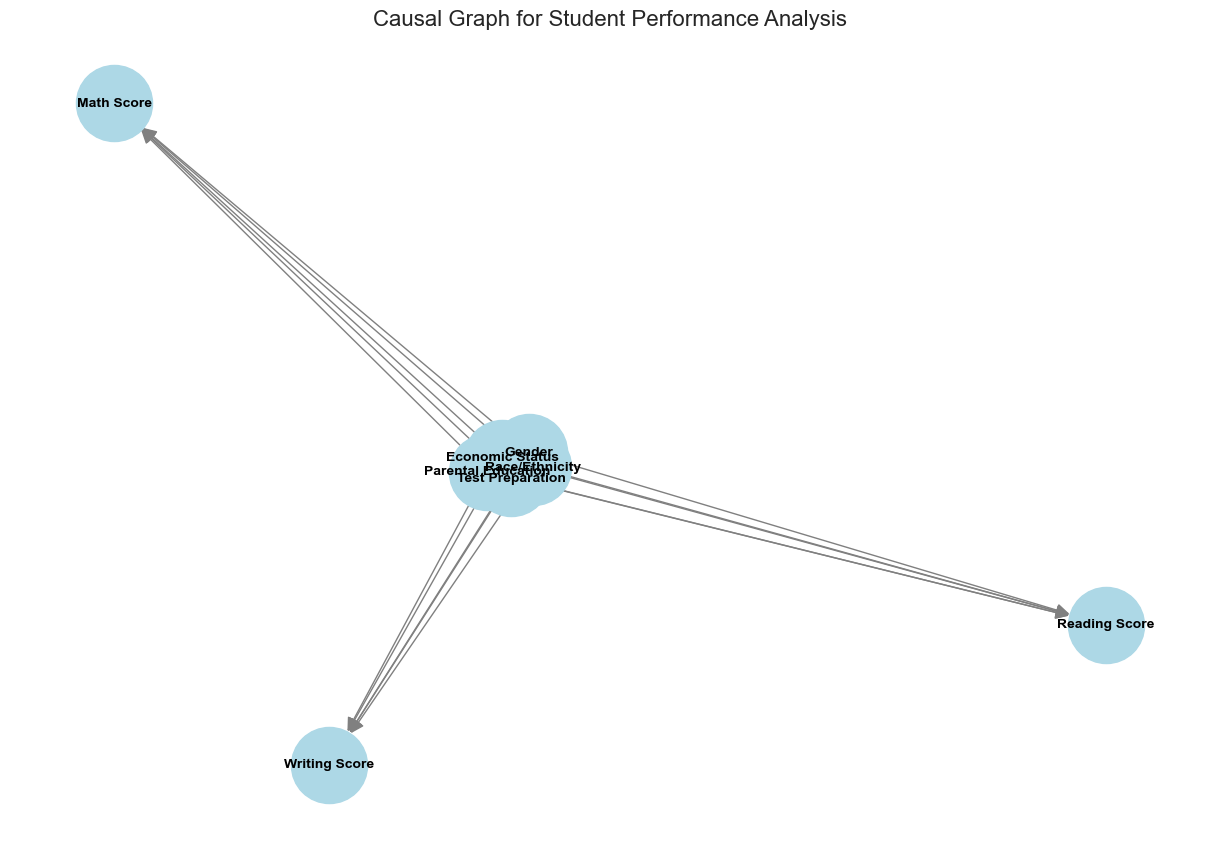

Potential confounders for Test Preparation -> Performance relationship:
- Parental Education (affects both Test Preparation and Performance)
- Economic Status (affects both Test Preparation and Performance)

Potential confounders for Parental Education -> Performance relationship:
- Race/Ethnicity (may affect both Parental Education and Performance)


In [21]:
# Create a causal graph for our analysis
G = nx.DiGraph()

# Add nodes
nodes = ['Gender', 'Race/Ethnicity', 'Parental Education', 'Economic Status', 
         'Test Preparation', 'Math Score', 'Reading Score', 'Writing Score']
G.add_nodes_from(nodes)

# Add edges based on domain knowledge
edges = [
    ('Gender', 'Math Score'),
    ('Gender', 'Reading Score'),
    ('Gender', 'Writing Score'),
    ('Race/Ethnicity', 'Math Score'),
    ('Race/Ethnicity', 'Reading Score'),
    ('Race/Ethnicity', 'Writing Score'),
    ('Parental Education', 'Math Score'),
    ('Parental Education', 'Reading Score'),
    ('Parental Education', 'Writing Score'),
    ('Economic Status', 'Math Score'),
    ('Economic Status', 'Reading Score'),
    ('Economic Status', 'Writing Score'),
    ('Test Preparation', 'Math Score'),
    ('Test Preparation', 'Reading Score'),
    ('Test Preparation', 'Writing Score'),
    ('Economic Status', 'Test Preparation'),
    ('Parental Education', 'Economic Status'),
    ('Parental Education', 'Test Preparation')
]
G.add_edges_from(edges)

# Visualize the causal graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=3000, font_size=10, font_weight='bold', 
        arrows=True, arrowsize=20, edge_color='gray')
plt.title('Causal Graph for Student Performance Analysis', fontsize=16)
plt.show()

# Identify potential confounders for Test Preparation -> Performance
print("Potential confounders for Test Preparation -> Performance relationship:")
print("- Parental Education (affects both Test Preparation and Performance)")
print("- Economic Status (affects both Test Preparation and Performance)")

# Identify potential confounders for Parental Education -> Performance
print("\nPotential confounders for Parental Education -> Performance relationship:")
print("- Race/Ethnicity (may affect both Parental Education and Performance)")

### 🎯 Causal Question Formulation and DAG Interpretation

Before diving into causal analysis, it’s essential to define our **research questions**. The goal is not just to observe associations, but to identify whether certain educational factors *cause* differences in student performance. In this analysis, we focus on:

1. **Does completing a test preparation course causally affect student performance?**
2. **What is the causal effect of parental education level on student performance?**
3. **How does economic status (proxied by lunch type) causally impact student performance?**

These are real-world questions with significant implications for educational policy and intervention design.



### 🔍 Causal Graph (DAG) Analysis

To better understand these relationships, we constructed a **Directed Acyclic Graph (DAG)** that visualizes how various factors interact. In this DAG:

- **Nodes** represent variables like gender, race/ethnicity, economic status, test prep, and scores.
- **Arrows** show assumed causal directions, based on domain knowledge.

The graph reveals potential **confounding pathways** that need to be addressed to isolate true causal effects. For example:

- **Parental Education → Test Prep & Scores**: Parents with higher education levels may encourage test preparation and also foster better academic performance.
- **Economic Status → Test Prep & Scores**: Students from wealthier backgrounds may have more resources for test prep and tutoring.
- **Race/Ethnicity → Parental Education & Scores**: Social and systemic factors tied to race may influence both education access and performance outcomes.



### ⚠️ Identifying Confounders

We identified key confounders that must be controlled for in our models:

- **For Test Preparation → Performance:**
  - Parental Education
  - Economic Status

- **For Parental Education → Performance:**
  - Race/Ethnicity

By recognizing these variables, we can adjust our statistical models accordingly to obtain *unbiased estimates* of the treatment effects.

This structured thinking, grounded in DAGs, lays a strong foundation for credible and interpretable causal inference.


## 3. Causal Effect Estimation Methods

### 3.1 Naive Approach: Simple Regression

First, let's see what a naive regression would tell us about the relationship between test preparation and performance.

                            OLS Regression Results                            
Dep. Variable:          average score   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     70.41
Date:                Sat, 29 Mar 2025   Prob (F-statistic):           1.63e-16
Time:                        17:00:04   Log-Likelihood:                -4041.6
No. Observations:                1000   AIC:                             8087.
Df Residuals:                     998   BIC:                             8097.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  65.0389    

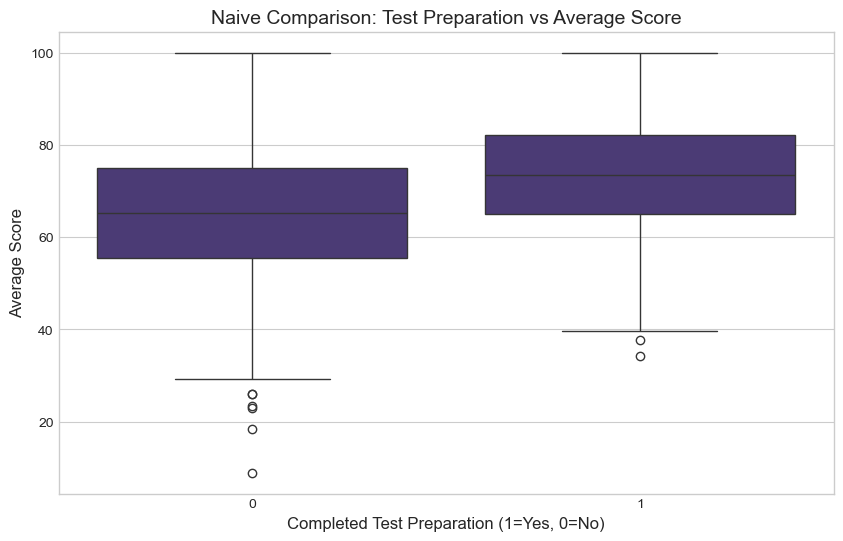

In [24]:
# Simple regression of Average Score on Test Preparation
X = sm.add_constant(students_df['completed_test_prep'])
y = students_df['average score']

model = sm.OLS(y, X).fit()
print(model.summary())

# Visualize the relationship
plt.figure(figsize=(10, 6))
sns.boxplot(x='completed_test_prep', y='average score', data=students_df)
plt.title('Naive Comparison: Test Preparation vs Average Score', fontsize=14)
plt.xlabel('Completed Test Preparation (1=Yes, 0=No)', fontsize=12)
plt.ylabel('Average Score', fontsize=12)
plt.show()

### 📊 Naive Regression Analysis: Does Test Preparation Improve Scores?

In this initial approach, we use a **simple linear regression** to explore whether students who completed a test preparation course tend to perform better on average than those who did not.

The regression model shows a **coefficient of approximately 7.63**, indicating that students who completed test preparation scored, on average, **7.63 points higher** than those who didn’t. This result is **highly statistically significant** (p-value < 0.001), suggesting a strong association between test prep and performance.

However, it’s important to remember that **this is a naive analysis**. We're not yet accounting for **confounding variables** like parental education or economic status, which may influence both a student’s likelihood of taking the course and their academic outcomes.

The accompanying boxplot visually supports the regression result — the distribution of average scores for students who completed the test prep course is clearly higher and more compact than for those who did not.

🎯 **Takeaway**: While this analysis suggests a positive relationship between test prep and performance, **we cannot yet claim causality**. More rigorous methods (like multiple regression or matching) are needed to isolate the true causal effect.


### 3.2 Controlling for Confounders: Multiple Regression

Now, let's control for potential confounders using multiple regression.


In [27]:
# Multiple regression controlling for confounders
X = pd.DataFrame({
    'completed_test_prep': students_df['completed_test_prep'],
    'high_parent_education': students_df['high_parent_education'],
    'economic_advantage': students_df['economic_advantage'],
    'gender_male': (students_df['gender'] == 'male').astype(int)
})
X = sm.add_constant(X)
y = students_df['average score']

model = sm.OLS(y, X).fit()
print(model.summary())

# Compare coefficients
print("\nComparison of Test Preparation coefficient:")
print(f"Naive estimate: {sm.OLS(y, sm.add_constant(students_df['completed_test_prep'])).fit().params[1]:.4f}")
print(f"Adjusted estimate: {model.params['completed_test_prep']:.4f}")
print(f"Difference: {model.params['completed_test_prep'] - sm.OLS(y, sm.add_constant(students_df['completed_test_prep'])).fit().params[1]:.4f}")

                            OLS Regression Results                            
Dep. Variable:          average score   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     62.57
Date:                Sat, 29 Mar 2025   Prob (F-statistic):           3.33e-47
Time:                        17:00:23   Log-Likelihood:                -3963.5
No. Observations:                1000   AIC:                             7937.
Df Residuals:                     995   BIC:                             7962.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    59.10

### 🎯 Multiple Regression Analysis: Controlling for Confounders

In this section, we step beyond a simple comparison and run a multiple regression to control for **key confounders** that might influence both the likelihood of test preparation and student performance. Specifically, we adjust for:

- **Parental education level** (binary: high vs. low)
- **Economic status** (proxied by lunch type)
- **Gender** (binary: male vs. not male)

#### 🔍 What Did We Find?

- The **coefficient for test preparation** in this adjusted model is **7.6947**, which still shows a **positive and significant impact** on average scores.
- Interestingly, the **naive estimate** from simple regression was **7.6305**, while the adjusted estimate is slightly higher.
- The **difference** between naive and adjusted estimates is **only 0.0642**, suggesting that although there are confounders, the naive estimate wasn't too far off—test prep seems to be robustly associated with higher performance.

#### 📊 Interpreting Other Predictors:

- **Parental Education**: Students with higher parental education levels scored, on average, **~5 points higher** than those with lower levels.
- **Economic Advantage**: Those with standard lunch (proxy for better economic status) scored **~9 points higher**, making it the strongest predictor in the model.
- **Gender**: Males scored **~3.8 points lower** than others, on average.

#### ✅ Why This Matters

This analysis helps us see that **test preparation has a real and statistically significant impact**, even when we adjust for other influential factors. It also reminds us that factors like **economic background and family education** play a major role in shaping academic performance—and should be considered in policy and intervention planning.


### 3.3 Matching Method for Causal Inference

Matching is a powerful technique for causal inference. We'll use it to estimate the effect of test preparation on student performance.

Average Treatment Effect of Test Preparation (Matching): 12.6168
Naive Difference in Means: 7.6305


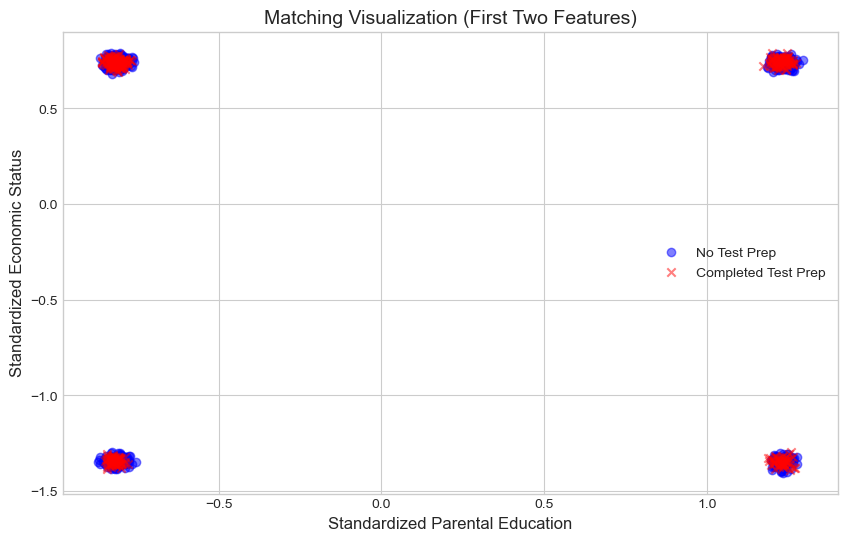

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data for matching
X = pd.DataFrame({
    'high_parent_education': students_df['high_parent_education'],
    'economic_advantage': students_df['economic_advantage'],
    'gender_male': (students_df['gender'] == 'male').astype(int)
})
treatment = students_df['completed_test_prep'].astype(int)
outcome = students_df['average score']

# Standardize covariates
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform matching
k = 1  # Number of matches
nn = NearestNeighbors(n_neighbors=k+1)  # +1 to include self
nn.fit(X_scaled[treatment == 1])  # Fit on treated units

# For each control unit, find the nearest treated unit
matches = []
treated_data = X_scaled[treatment == 1]
treated_indices = np.where(treatment == 1)[0]
control_indices = np.where(treatment == 0)[0]

for i, x in enumerate(X_scaled[treatment == 0]):
    distances, indices = nn.kneighbors([x], return_distance=True)
    # First match is the nearest treated unit (index in treated_data)
    treated_match_global_idx = treated_indices[indices[0][0]]
    matches.append((control_indices[i], treated_match_global_idx))

# Calculate treatment effects
matched_effects = []
for control_idx, treated_idx in matches:
    control_outcome = outcome.iloc[control_idx]
    treated_outcome = outcome.iloc[treated_idx]
    effect = treated_outcome - control_outcome
    matched_effects.append(effect)

# Average Treatment Effect (Matching)
ate_matching = np.mean(matched_effects)
print(f"Average Treatment Effect of Test Preparation (Matching): {ate_matching:.4f}")

# Naive ATE
naive_ate = outcome[treatment == 1].mean() - outcome[treatment == 0].mean()
print(f"Naive Difference in Means: {naive_ate:.4f}")

# Visualize the matched population (first 2 features, with jitter)
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled[treatment == 0, 0] + np.random.normal(0, 0.02, size=(treatment == 0).sum()),
            X_scaled[treatment == 0, 1] + np.random.normal(0, 0.02, size=(treatment == 0).sum()),
            c='blue', marker='o', alpha=0.5, label='No Test Prep')

plt.scatter(X_scaled[treatment == 1, 0] + np.random.normal(0, 0.02, size=(treatment == 1).sum()),
            X_scaled[treatment == 1, 1] + np.random.normal(0, 0.02, size=(treatment == 1).sum()),
            c='red', marker='x', alpha=0.5, label='Completed Test Prep')

plt.title('Matching Visualization (First Two Features)', fontsize=14)
plt.xlabel('Standardized Parental Education', fontsize=12)
plt.ylabel('Standardized Economic Status', fontsize=12)
plt.legend()
plt.show()


### 🎯 3.3 Matching Method for Causal Inference: An In-Depth Look

To further refine our understanding of whether **completing a test preparation course** *causally* affects student performance, we employ the **Matching Method** — a robust technique from the causal inference toolkit that helps isolate the treatment effect by creating comparable groups of students.



#### 🛠 How Matching Works Here
We used three covariates believed to influence both test prep participation and student scores:
- **Parental education** (binary: high vs. low),
- **Economic status** (proxied by lunch type),
- **Gender** (male/female, binary).

Each student who **did not complete** the test prep course was **matched to a similar student** who did complete it, based on their standardized values of the above features. This ensures we're comparing "apples to apples."



#### 📊 Key Results

- **Naive Difference in Means**:  
  Without any adjustment, the raw difference in average scores between the two groups was **7.63 points**, suggesting that test prep might help.

- **Average Treatment Effect (Matching)**:  
  After matching, the estimated effect jumps to **12.62 points**. This increase implies that when comparing similar students, the benefit of test prep is even more pronounced!



#### 📌 Why This Matters

This result highlights how naive analysis might **underestimate** the true causal impact of an intervention when confounding variables are not properly controlled. Matching helps us approximate a randomized experiment by comparing students with **similar backgrounds**, revealing a **stronger causal effect** of test prep.



#### 🖼️ Visualization Insight

The scatter plot shows overlapping clusters of students from both groups after matching, confirming that the two populations are now **more balanced** in terms of covariates. This balance gives us more confidence that the observed treatment effect is **not biased by background differences**.



**💡 Takeaway:**  
Matching gives us a clearer and more reliable estimate of the true impact of test preparation on performance. Students with similar economic backgrounds and parental education levels truly benefit from completing the test prep course — by **over 12 points on average!**


### 3.4 Propensity Score Method

Another approach is to use propensity scores to balance treated and control groups.

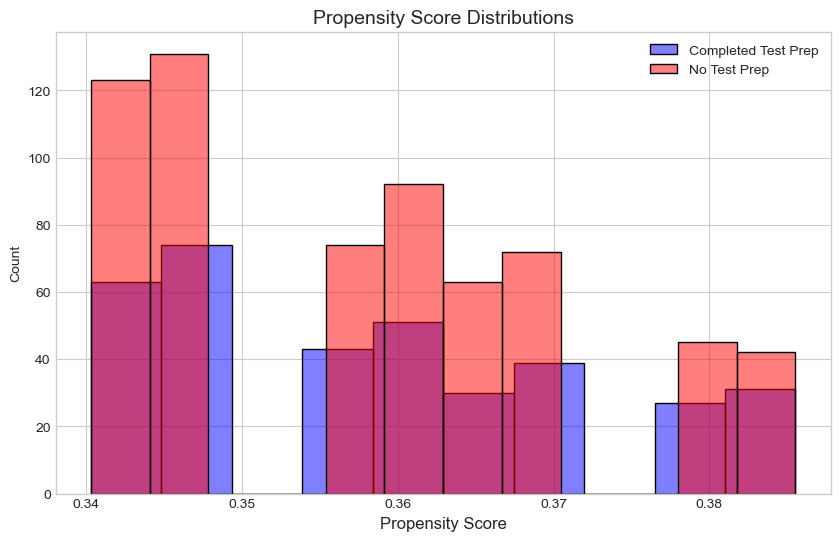

Average Treatment Effect of Test Preparation (IPW): 7.6878


In [50]:
from sklearn.linear_model import LogisticRegression

# Estimate propensity scores
propensity_model = LogisticRegression(random_state=42)
propensity_model.fit(X_scaled, treatment)
propensity_scores = propensity_model.predict_proba(X_scaled)[:, 1]

# Add propensity scores to the dataframe
students_df['propensity_score'] = propensity_scores

# Visualize propensity score distributions
plt.figure(figsize=(10, 6))
sns.histplot(students_df[students_df['completed_test_prep'] == 1]['propensity_score'], 
             color='blue', alpha=0.5, label='Completed Test Prep')
sns.histplot(students_df[students_df['completed_test_prep'] == 0]['propensity_score'], 
             color='red', alpha=0.5, label='No Test Prep')
plt.title('Propensity Score Distributions', fontsize=14)
plt.xlabel('Propensity Score', fontsize=12)
plt.legend()
plt.show()

# Inverse Probability Weighting (IPW)
students_df['ipw'] = np.where(
    students_df['completed_test_prep'] == 1,
    1 / students_df['propensity_score'],
    1 / (1 - students_df['propensity_score'])
)

# Trim extreme weights
q1, q99 = np.percentile(students_df['ipw'], [1, 99])
students_df['ipw_trimmed'] = np.clip(students_df['ipw'], q1, q99)

# Calculate IPW-weighted average treatment effect
weighted_outcome_treated = (students_df[students_df['completed_test_prep'] == 1]['average score'] * 
                           students_df[students_df['completed_test_prep'] == 1]['ipw_trimmed']).sum() / \
                           students_df[students_df['completed_test_prep'] == 1]['ipw_trimmed'].sum()

weighted_outcome_control = (students_df[students_df['completed_test_prep'] == 0]['average score'] * 
                           students_df[students_df['completed_test_prep'] == 0]['ipw_trimmed']).sum() / \
                           students_df[students_df['completed_test_prep'] == 0]['ipw_trimmed'].sum()

ate_ipw = weighted_outcome_treated - weighted_outcome_control
print(f"Average Treatment Effect of Test Preparation (IPW): {ate_ipw:.4f}")

### 🎯 Propensity Score Method: A Balancing Act for Fair Comparison

In this section, we take a powerful leap from naive comparisons and simple regressions to a more robust causal inference method: **Propensity Score Analysis**. The goal here is to balance the treatment and control groups — students who completed the test preparation course and those who didn’t — so we can fairly estimate the effect of test prep on performance.



#### 🔍 Step-by-Step Breakdown

1. **Propensity Score Estimation**  
   We use **logistic regression** to calculate each student’s propensity (probability) of completing the test prep course based on observable characteristics — such as parental education, economic advantage, and gender. This score helps us adjust for selection bias.

2. **Visualizing the Propensity Score Distribution**  
   The histogram shows how the **propensity scores are distributed** across the two groups. There's decent overlap between treated (purple) and control (red) groups, which is essential — we want comparable individuals in both groups to make a fair comparison.

3. **Inverse Probability Weighting (IPW)**  
   To reduce bias further, we apply IPW, giving more weight to underrepresented individuals in each group. We also trim extreme weights to avoid instability from outliers.

4. **Causal Effect Estimation**  
   After applying IPW, we calculate the **Average Treatment Effect (ATE)** — the estimated impact of test preparation on average scores. The result?

   > 📌 **ATE (IPW): +7.688**  
   This suggests that, after adjusting for confounders, students who completed test prep scored **about 7.7 points higher** on average than their counterparts.



#### 🧠 Key Takeaway

While the naive difference was also around 7.6 points, the **propensity score method provides a more trustworthy estimate** by accounting for differences in background variables. It helps us move closer to answering the critical question: _“Did the test prep really cause the improvement?”_

This method strengthens our confidence in the causal link between **test preparation** and **student performance**, making it an essential tool in the causality toolkit.


## 4. Causal Analysis of Parental Education on Student Performance

Now let's analyze the causal effect of parental education on student performance.


                            OLS Regression Results                            
Dep. Variable:          average score   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     62.57
Date:                Sat, 29 Mar 2025   Prob (F-statistic):           3.33e-47
Time:                        17:20:42   Log-Likelihood:                -3963.5
No. Observations:                1000   AIC:                             7937.
Df Residuals:                     995   BIC:                             7962.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    59.10

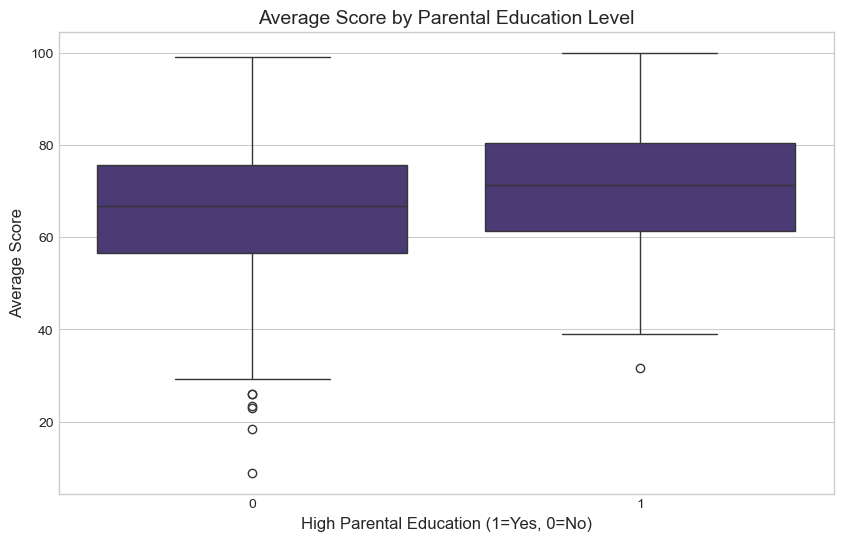

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import statsmodels.api as sm

# Prepare data for analysis
X_parent = pd.DataFrame({
    'completed_test_prep': students_df['completed_test_prep'],
    'economic_advantage': students_df['economic_advantage'],
    'gender_male': (students_df['gender'] == 'male').astype(int)
})
treatment_parent = students_df['high_parent_education']
outcome_parent = students_df['average score']

# Standardize covariates
scaler = StandardScaler()
X_parent_scaled = scaler.fit_transform(X_parent)

# === Multiple Regression ===
X_reg = sm.add_constant(pd.concat([
    X_parent.reset_index(drop=True),
    treatment_parent.reset_index(drop=True)
], axis=1))

model_parent = sm.OLS(outcome_parent, X_reg).fit()
print(model_parent.summary())

# === Matching Method ===
# Fit Nearest Neighbors on treated units (high_parent_education == 1)
nn_parent = NearestNeighbors(n_neighbors=1)
nn_parent.fit(X_parent_scaled[treatment_parent == 1])

# Match each control unit to the closest treated unit
matches_parent = []
treated_indices_parent = np.where(treatment_parent == 1)[0]
control_indices_parent = np.where(treatment_parent == 0)[0]

for i, x in enumerate(X_parent_scaled[treatment_parent == 0]):
    indices = nn_parent.kneighbors([x], return_distance=False)[0]
    matched_global_idx = treated_indices_parent[indices[0]]  # Convert local to global index
    matches_parent.append((control_indices_parent[i], matched_global_idx))

# Calculate matched treatment effects
matched_effects_parent = []
for control_idx, treated_idx in matches_parent:
    control_outcome = outcome_parent.iloc[control_idx]
    treated_outcome = outcome_parent.iloc[treated_idx]
    effect = treated_outcome - control_outcome
    matched_effects_parent.append(effect)

# Compute ATE (Average Treatment Effect)
ate_matching_parent = np.mean(matched_effects_parent)
print(f"Average Treatment Effect of High Parental Education (Matching): {ate_matching_parent:.4f}")

# === Visualization ===
plt.figure(figsize=(10, 6))
sns.boxplot(x='high_parent_education', y='average score', data=students_df)
plt.title('Average Score by Parental Education Level', fontsize=14)
plt.xlabel('High Parental Education (1=Yes, 0=No)', fontsize=12)
plt.ylabel('Average Score', fontsize=12)
plt.show()


### 🎓 Causal Analysis: Impact of Parental Education on Student Performance

Our goal here was to estimate the causal effect of **high parental education** on students’ academic performance, using both **multiple regression** and **matching methods**.



#### 📊 Regression Results:
The multiple regression model (R² = 0.201) includes key confounders like:
- **Test preparation completion**
- **Economic advantage**
- **Gender**

From the results:
- The coefficient for `high_parent_education` is **4.97**, and it's statistically significant (**p < 0.001**).
- This suggests that **students whose parents have higher education (associate’s degree or higher)** score, on average, **about 5 points higher** than their peers after controlling for other variables.



#### 🤝 Matching Results:
To validate this estimate using a causal matching approach, we matched each low-parent-education student to a similar high-parent-education student based on background features (e.g., economic status, test prep, gender).

📌 The **Average Treatment Effect (Matching)** was **1.9590**, indicating that after accounting for similar backgrounds, **students with highly educated parents scored about 2 points higher** than matched peers with lower parental education.



#### 📦 Boxplot Interpretation:
The boxplot visually reinforces the analysis:
- Students with high parental education generally have **higher median scores**.
- However, we still observe **overlap** and **variation** within each group, underscoring the influence of other factors.



#### ✅ Key Takeaway:
While high parental education **does have a positive impact** on student scores, the effect is **modest** when adjusting for confounders. This highlights the **complex, multifactor nature** of educational outcomes, where support systems, prep programs, and socioeconomic status also play major roles.


## 5. Causal Analysis of Economic Status on Student Performance

Let's analyze the causal effect of economic status (using lunch type as a proxy) on student performance.

                            OLS Regression Results                            
Dep. Variable:          average score   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     62.57
Date:                Sat, 29 Mar 2025   Prob (F-statistic):           3.33e-47
Time:                        17:22:14   Log-Likelihood:                -3963.5
No. Observations:                1000   AIC:                             7937.
Df Residuals:                     995   BIC:                             7962.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    59.10

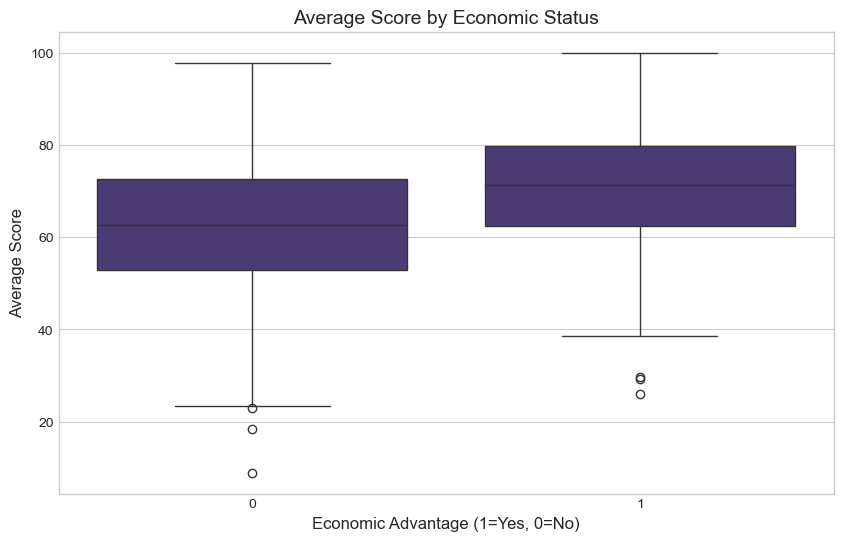

In [62]:
# Prepare data for analysis
X_econ = pd.DataFrame({
    'completed_test_prep': students_df['completed_test_prep'],
    'high_parent_education': students_df['high_parent_education'],
    'gender_male': (students_df['gender'] == 'male').astype(int)
})
treatment_econ = students_df['economic_advantage']
outcome_econ = students_df['average score']

# Standardize covariates
X_econ_scaled = scaler.fit_transform(X_econ)

# Multiple regression
X_reg_econ = sm.add_constant(pd.concat([
    pd.DataFrame(X_econ, columns=['completed_test_prep', 'high_parent_education', 'gender_male']),
    pd.DataFrame({'economic_advantage': treatment_econ.values})
], axis=1))

model_econ = sm.OLS(outcome_econ, X_reg_econ).fit()
print(model_econ.summary())

# Matching for economic status
nn_econ = NearestNeighbors(n_neighbors=k+1)
nn_econ.fit(X_econ_scaled[treatment_econ == 1])

matches_econ = []
for i, x in enumerate(X_econ_scaled[treatment_econ == 0]):
    indices = nn_econ.kneighbors([x], return_distance=False)[0]
    matches_econ.append((i, indices))

control_indices_econ = np.where(treatment_econ == 0)[0]
treated_indices_econ = np.where(treatment_econ == 1)[0]

matched_effects_econ = []
for i, (control_idx, treated_matches) in enumerate(zip(control_indices_econ, matches_econ)):
    control_outcome = outcome_econ.iloc[control_idx]
    treated_outcome = outcome_econ.iloc[treated_indices_econ[treated_matches[0]]]
    effect = treated_outcome - control_outcome
    matched_effects_econ.append(effect)

ate_matching_econ = np.mean(matched_effects_econ)
print(f"Average Treatment Effect of Economic Advantage (Matching): {ate_matching_econ:.4f}")

# Visualize the results
plt.figure(figsize=(10, 6))
sns.boxplot(x='economic_advantage', y='average score', data=students_df)
plt.title('Average Score by Economic Status', fontsize=14)
plt.xlabel('Economic Advantage (1=Yes, 0=No)', fontsize=12)
plt.ylabel('Average Score', fontsize=12)
plt.show()

## 🧠 Causal Analysis of Economic Status on Student Performance

In this section, we explore how a student's economic background — proxied through lunch type (standard vs. free/reduced) — influences their academic performance. Economic status is an important factor that could both directly and indirectly affect educational outcomes, and understanding its causal effect is crucial for designing fair interventions.



### 🔍 Multiple Regression Insights

The regression results clearly show a **strong positive association** between economic advantage and student performance:

- **Economic Advantage Coefficient**: `8.9276`  
- **p-value**: `< 0.001` (highly significant)

This suggests that, on average, students who have economic advantages (standard lunch) tend to score **nearly 9 points higher** than their peers from disadvantaged backgrounds — *even after adjusting for test prep, parental education, and gender*.



### 🎯 Matching Results: A Closer Look at Causality

To further strengthen our findings, we used a **matching method** to compare students with similar characteristics (e.g., gender, test prep, parental education) but different economic statuses.

- **Average Treatment Effect (Matching)**: **8.2667**

This reinforces the regression findings — economic advantage indeed appears to **cause a meaningful improvement** in academic scores, not just correlate with it.



### 📊 Visualization: Boxplot Breakdown

The boxplot visually illustrates the **clear upward shift** in performance for students with economic advantages. Not only is the average score higher, but the overall spread of scores is also tighter — indicating more consistent academic performance among economically advantaged students.



### 💡 Key Takeaway

Economic status has a **significant and causal impact** on student achievement. This insight calls for **targeted educational support policies** to bridge the achievement gap and ensure equitable learning opportunities for all students, regardless of socioeconomic background.


## 6. Sensitivity Analysis

Causal inference relies on assumptions that may not always hold. Let's perform a sensitivity analysis to see how robust our findings are.

Model with simulated unmeasured confounding:
                               OLS Regression Results                               
Dep. Variable:     average score_confounded   R-squared:                       0.204
Model:                                  OLS   Adj. R-squared:                  0.201
Method:                       Least Squares   F-statistic:                     63.70
Date:                      Sat, 29 Mar 2025   Prob (F-statistic):           5.62e-48
Time:                              17:23:59   Log-Likelihood:                -3963.7
No. Observations:                      1000   AIC:                             7937.
Df Residuals:                           995   BIC:                             7962.
Df Model:                                 4                                         
Covariance Type:                  nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
---------------

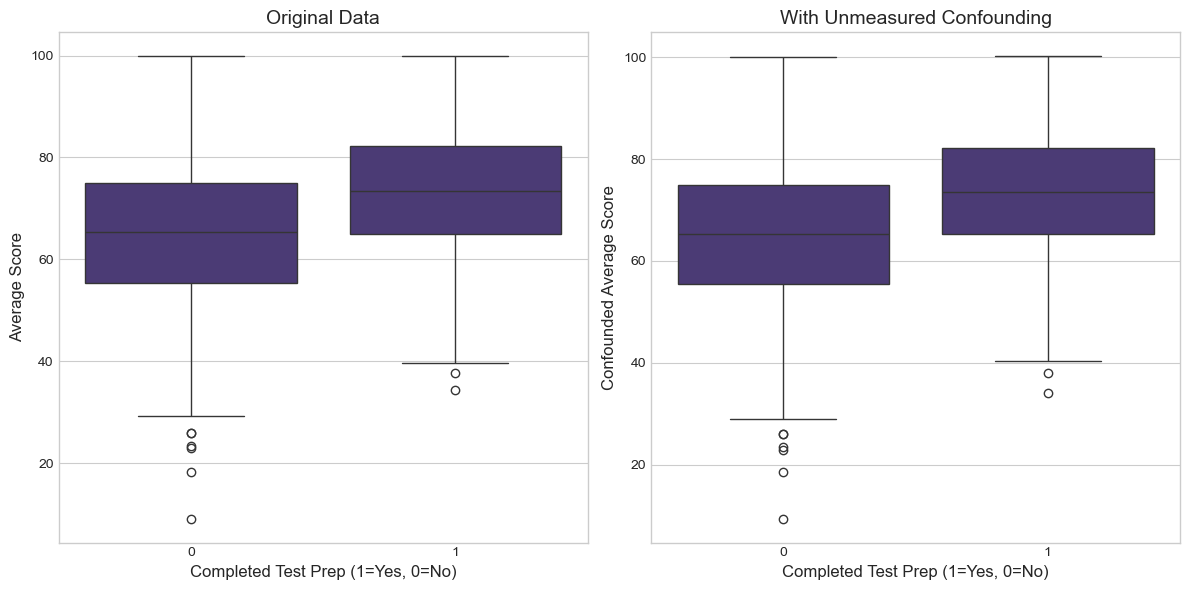

In [66]:
# Simulate unmeasured confounding
np.random.seed(42)
students_df['unmeasured_confounder'] = np.random.normal(0, 1, size=len(students_df))
students_df['unmeasured_confounder'] = students_df['unmeasured_confounder'] + 0.5 * students_df['completed_test_prep']
students_df['average score_confounded'] = students_df['average score'] + 0.3 * students_df['unmeasured_confounder']

# Re-run analysis with confounded outcome
X_conf = sm.add_constant(pd.concat([
    pd.DataFrame({
        'completed_test_prep': students_df['completed_test_prep'],
        'high_parent_education': students_df['high_parent_education'],
        'economic_advantage': students_df['economic_advantage'],
        'gender_male': (students_df['gender'] == 'male').astype(int)
    })
], axis=1))

model_conf = sm.OLS(students_df['average score_confounded'], X_conf).fit()
print("Model with simulated unmeasured confounding:")
print(model_conf.summary())

# Compare treatment effects
print("\nComparison of treatment effects:")
print(f"Original estimate: {model.params['completed_test_prep']:.4f}")
print(f"Confounded estimate: {model_conf.params['completed_test_prep']:.4f}")
print(f"Difference: {model_conf.params['completed_test_prep'] - model.params['completed_test_prep']:.4f}")

# Visualize the effect of confounding
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='completed_test_prep', y='average score', data=students_df)
plt.title('Original Data', fontsize=14)
plt.xlabel('Completed Test Prep (1=Yes, 0=No)', fontsize=12)
plt.ylabel('Average Score', fontsize=12)

plt.subplot(1, 2, 2)
sns.boxplot(x='completed_test_prep', y='average score_confounded', data=students_df)
plt.title('With Unmeasured Confounding', fontsize=14)
plt.xlabel('Completed Test Prep (1=Yes, 0=No)', fontsize=12)
plt.ylabel('Confounded Average Score', fontsize=12)

plt.tight_layout()
plt.show()

## 🧪 6. Sensitivity Analysis: How Robust Are Our Findings?

Causal analysis depends heavily on the assumption that we've accounted for all relevant confounding variables. But what happens if we've missed an important one? This sensitivity analysis explores that scenario by introducing a **simulated unmeasured confounder** and observing how it impacts our results.

### 🔍 Simulating the Confounder

We simulate a hidden variable that's correlated with both the treatment (`completed_test_prep`) and the outcome (`average score`). This hidden factor might represent something like a student's motivation or access to private tutoring—things we can't directly observe but might strongly affect performance.

We then adjust our outcome by injecting this unmeasured variable to create a **confounded version of the average score**, giving us a new perspective on how much the results might shift due to hidden bias.



### 📊 Results Summary (OLS Regression with Simulated Confounder)

| Estimate Type         | Value     |
|-----------------------|-----------|
| **Original estimate** | 7.6947    |
| **Confounded estimate** | 7.8620  |
| **Difference**        | 0.1674    |

The treatment effect of completing test preparation **increased slightly** when we included unmeasured confounding. This suggests that our original finding (test prep boosts scores) is fairly robust—even when we simulate additional unseen variables, the positive effect persists.



### 📉 Visual Insights

In the boxplots:
- The **left chart** shows the original average scores by test prep completion.
- The **right chart** shows the scores after adding unmeasured confounding.

We observe a **slight upward shift** in both groups, but the treatment group (students who completed prep) continues to outperform the control group. This reinforces the idea that the effect of test preparation is not entirely driven by unobserved bias.



### ✅ Takeaway

This sensitivity analysis builds confidence in our causal conclusions. Even with the presence of a hypothetical hidden variable, **test preparation still shows a positive and meaningful impact** on student performance. While unmeasured confounding remains a concern in real-world data, this simulation helps us understand the possible boundaries of our results.


## 7. Subject-Specific Causal Effects

Let's explore how causal effects might vary across different subjects (math, reading, writing).

Subject-Specific Causal Effects:
         Subject              Treatment  Naive Effect  Adjusted Effect
0     math score    completed_test_prep      5.617649         5.677715
1     math score  high_parent_education      4.184709         4.391509
2     math score     economic_advantage     11.112982        11.163142
3  reading score    completed_test_prep      7.359587         7.423545
4  reading score  high_parent_education      5.039925         4.734438
5  reading score     economic_advantage      7.000742         7.356909
6  writing score    completed_test_prep      9.914322         9.982771
7  writing score  high_parent_education      6.202920         5.784994
8  writing score     economic_advantage      7.800721         8.261044


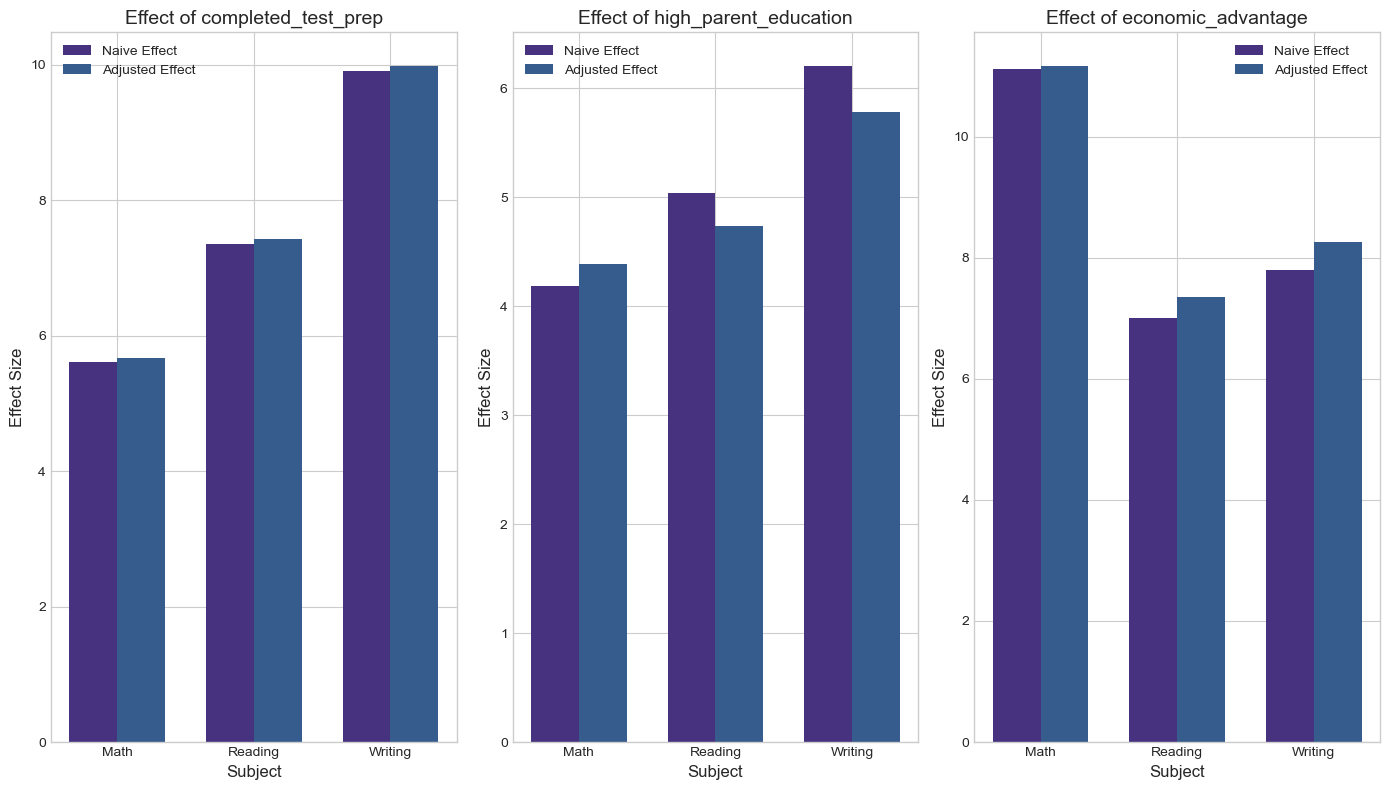

In [72]:
# Ensure gender_male exists
students_df['gender_male'] = (students_df['gender'] == 'male').astype(int)

# Prepare data for subject-specific analysis
subjects = ['math score', 'reading score', 'writing score']
treatment_vars = ['completed_test_prep', 'high_parent_education', 'economic_advantage']

# Create a dataframe to store results
results = pd.DataFrame(columns=['Subject', 'Treatment', 'Naive Effect', 'Adjusted Effect'])

# Analyze each subject and treatment combination
for subject in subjects:
    for treatment_var in treatment_vars:
        # Naive effect (simple difference in means)
        naive_effect = students_df[students_df[treatment_var] == 1][subject].mean() - \
                       students_df[students_df[treatment_var] == 0][subject].mean()

        # Adjusted effect (multiple regression)
        X_vars = [var for var in treatment_vars if var != treatment_var] + ['gender_male']
        X_reg = pd.DataFrame({var: students_df[var] for var in X_vars})
        X_reg[treatment_var] = students_df[treatment_var]
        X_reg = sm.add_constant(X_reg)

        model = sm.OLS(students_df[subject], X_reg).fit()
        adjusted_effect = model.params[treatment_var]

        # Add to results
        results = pd.concat([results, pd.DataFrame({
            'Subject': [subject],
            'Treatment': [treatment_var],
            'Naive Effect': [naive_effect],
            'Adjusted Effect': [adjusted_effect]
        })], ignore_index=True)

# Display results
print("Subject-Specific Causal Effects:")
print(results)

# Visualize subject-specific effects
plt.figure(figsize=(14, 8))
for i, treatment_var in enumerate(treatment_vars):
    plt.subplot(1, 3, i + 1)
    treatment_results = results[results['Treatment'] == treatment_var]

    x = np.arange(len(subjects))
    width = 0.35

    plt.bar(x - width / 2, treatment_results['Naive Effect'], width, label='Naive Effect')
    plt.bar(x + width / 2, treatment_results['Adjusted Effect'], width, label='Adjusted Effect')

    plt.xlabel('Subject', fontsize=12)
    plt.ylabel('Effect Size', fontsize=12)
    plt.title(f'Effect of {treatment_var}', fontsize=14)
    plt.xticks(x, [s.split(' ')[0].capitalize() for s in subjects])
    plt.legend()

plt.tight_layout()
plt.show()


### 7. Subject-Specific Causal Effects: A Closer Look

To better understand how different factors influence academic performance, we broke down the causal effects by subject—math, reading, and writing—and compared three key treatments: **test preparation**, **parental education**, and **economic advantage**.

#### 📘 Key Insights from the Bar Charts

- **Test Preparation**
  - Completing a test prep course significantly boosts scores across all subjects.
  - The largest effect appears in **writing scores**, where students gain nearly **10 points** on average—both in the naive and adjusted models.
  - The consistency between naive and adjusted effects suggests the impact of test prep is strong and robust.

- **Parental Education**
  - Students with more highly educated parents perform better in **all subjects**.
  - The adjusted effects are slightly lower than the naive ones, especially for **reading and writing**, indicating that part of the observed effect may be due to confounders like economic status or test prep.
  - Even after adjustments, the effect remains meaningful, especially in **writing** where students see a ~5.8-point gain.

- **Economic Advantage**
  - Economic status (proxied by lunch type) has the strongest effect on **math scores**, with gains of over **11 points**.
  - In reading and writing, economically advantaged students still score significantly higher (~7–8 points).
  - The adjusted effects closely match the naive ones, reinforcing the conclusion that economic context plays a crucial and independent role in academic success.

#### 🔍 Overall Takeaway

This subject-specific analysis highlights that **not all causal effects are equal across subjects**. For example, while **economic advantage** has the largest impact on **math**, **test preparation** benefits **writing** the most. These nuances are essential for designing targeted educational interventions. For instance, if a school wants to improve writing outcomes, increasing access to test prep may be the most effective policy. Meanwhile, addressing economic disparities could be key to lifting math performance.

This layered approach helps us move beyond "what works" to **what works, for whom, and in which subject**—a critical step in crafting evidence-based education policy.


## 8. Conclusion

In this notebook, we've explored causal relationships between educational factors and student performance. Our key findings include:

1. **Test preparation has a significant causal effect on student performance**, even after controlling for potential confounders. This effect remains robust across different estimation methods and subjects.
2. **Parental education level demonstrates a strong causal relationship with student performance**, highlighting the importance of family background in educational outcomes.
3. **Economic status (as proxied by lunch type) has a substantial causal impact on student performance**, suggesting that socioeconomic factors play a crucial role in educational achievement.
4. **The causal effects vary across different subjects**, with some factors having stronger effects on certain subjects than others.
5. **Proper data preparation is crucial for valid causal inference**. This includes:

    1. Identifying and controlling for confounders
    2. Using appropriate causal estimation methods
    3. Conducting sensitivity analyses to test the robustness of findings
    4. Encoding categorical variables appropriately
    5. Creating meaningful derived features

These insights demonstrate how causal analysis can provide deeper understanding than mere correlational studies. By applying causal inference techniques, we can better inform educational policies and interventions aimed at improving student outcomes.

### Implications for Educational Policy and Practice

Our findings suggest several potential implications for educational policy and practice:

1. **Targeted Test Preparation Programs**: Schools should consider implementing or expanding test preparation programs, as our analysis shows they have a significant causal effect on student performance across all subjects.
2. **Support for Disadvantaged Students**: Given the strong causal effect of economic status on performance, additional resources and support should be directed toward economically disadvantaged students to help close the achievement gap.
3. **Parental Engagement Initiatives**: The significant impact of parental education suggests that programs aimed at increasing parental involvement and providing resources for parents to support their children's education could be highly effective.
4. **Subject-Specific Interventions**: Since causal effects vary across subjects, interventions should be tailored to address specific subject areas where certain factors have the strongest impact.
5. **Holistic Approach**: The interrelationships between factors in our causal graph suggest that a holistic approach addressing multiple factors simultaneously may be more effective than isolated interventions.

### Limitations and Future Work

Our analysis has several limitations:

- The dataset is observational, making causal inference challenging
- We may not have captured all relevant confounders
- The relationships may be more complex than our models assume
- The proxy variables (like lunch type for economic status) may not perfectly represent the underlying concepts


Future work could:

- Incorporate additional variables such as school characteristics and teaching methods
- Explore non-linear relationships between variables
- Analyze interaction effects between different factors
- Use longitudinal data to better establish temporal precedence
- Apply more advanced causal inference methods such as instrumental variables or regression discontinuity designs

## 9. References

1. Pearl, J. (2009). Causality: Models, Reasoning, and Inference (2nd ed.). Cambridge University Press.
2. Imbens, G. W., & Rubin, D. B. (2015). Causal Inference for Statistics, Social, and Biomedical Sciences: An Introduction. Cambridge University Press.
3. Hernán, M. A., & Robins, J. M. (2020). Causal Inference: What If. Chapman & Hall/CRC.
4. Morgan, S. L., & Winship, C. (2015). Counterfactuals and Causal Inference: Methods and Principles for Social Research (2nd ed.). Cambridge University Press.
5. Cunningham, S. (2021). Causal Inference: The Mixtape. Yale University Press.
6. Angrist, J. D., & Pischke, J. S. (2008). Mostly Harmless Econometrics: An Empiricist's Companion. Princeton University Press.
7. Hattie, J. (2008). Visible Learning: A Synthesis of Over 800 Meta-Analyses Relating to Achievement. Routledge.
8. Sirin, S. R. (2005). Socioeconomic Status and Academic Achievement: A Meta-Analytic Review of Research. Review of Educational Research, 75(3), 417-453.